In [ ]:
# Group Members: Emily Rude, Ye Sheng, Tiffany Valitis, Leon Cai

# Final Project: Predicting the political affiliations of US Counties

The goal of this project is to predict whether a given county in the U.S. leans Democratic or Republican based on characteristics such as age, educational level and racial breakdown, the types of industries that its residents work in, and median income. For the purposes of this project, a county is classified as Democratic if the Democratic presidental candidate had the highest percentage of votes in 2016, and Republican if the Republican presidental candidate had the highest percentage of votes in 2016. The dataset we are using, which shows the Democratic/Republican voting breakdown for every county in the U.S. and the charactersitics of each of these counties can be found [here](https://public.opendatasoft.com/explore/dataset/usa-2016-presidential-election-by-county/export/?disjunctive.state).


In [1]:
#You may add additional imports
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
import math
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline

## Importing the Data and Feature Selection

While the given dataset includes a vast amount of information on each county, many of these features can be trimmed because either two or more features are closely correlated to each other and thus not all of those features are needed, or there is little or no correlation between those features and a county's political affiliation. The features selected below are the most indicative of a county's political characteristics. The percincts feature was left out for example because the votes feature was a similar indicator of the county's size, and the weather features were left out for example because they were lowly correlated to political affiliation.

In [2]:
# Read the data from csv file
col_names = []
for i in range(33):
    if i == 0:
        col_names.append('State')
    if i == 1:
        col_names.append('Fips')
    if i == 2:
        col_names.append('County')
    if i == 3:
        col_names.append('Votes')
    if i == 4:
        col_names.append('Republicans 2016')
    if i == 5:
        col_names.append('Democrats 2016')
    if i == 6:
        col_names.append('Republicans 2012')
    if i == 7:
        col_names.append('Republicans 2008')
    if i == 8:
        col_names.append('Democrats 2012')
    if i == 9:
        col_names.append('Democrats 2008')
    if i == 10:
        col_names.append('Less Than High School Diploma')
    if i == 11:
        col_names.append('At Least High School Diploma')
    if i == 12:
        col_names.append('At Least Bachelors Degree')
    if i == 13:
        col_names.append('Graduate Degree')
    if i == 14:
        col_names.append('Median Earnings 2010')
    if i == 15:
        col_names.append('Total Population')
    if i == 16:
        col_names.append('Poverty Rate below federal poverty threshold')
    if i == 17:
        col_names.append('Management professional and related occupations')
    if i == 18:
        col_names.append('Service occupations')
    if i == 19:
        col_names.append('Sales and office occupations')
    if i == 20:
        col_names.append('Farming fishing and forestry occupations')
    if i == 21:
        col_names.append('Construction extraction maintenance and repair occupations')
    if i == 22:
        col_names.append('Production transportation and material moving occupations')
    if i == 23:
        col_names.append('White')
    if i == 24:
        col_names.append('Black')
    if i == 25:
        col_names.append('Hispanic')
    if i == 26:
        col_names.append('Asian')
    if i == 27:
        col_names.append('Amerindian')
    if i == 28:
        col_names.append('Other Race')
    if i == 29:
        col_names.append('Median Age')
    if i == 30:
        col_names.append('Uninsured')
    if i == 31:
        col_names.append('Unemployment')
    if i == 32:
        col_names.append('Violent crime')
        
data = pd.read_csv("2016_election_dataset.csv", names = col_names, index_col=False)
print(data.shape)
data.head(10)

(3114, 33)


,State,Fips,County,Votes,Republicans 2016,Democrats 2016,Republicans 2012,Republicans 2008,Democrats 2012,Democrats 2008,...,White,Black,Hispanic,Asian,Amerindian,Other Race,Median Age,Uninsured,Unemployment,Violent crime
0,MN,27017,"Carlton County, Minnesota",18059.0,45.185226,46.846448,35.723584,35.497859,61.775873,62.339422,...,89.50,1.35,1.40,0.55,5.40,1.90,40.1,0.112,0.071,124.41
1,KS,20127,"Morris County, Kansas",2568.0,69.704050,22.819315,69.203747,65.997888,28.024980,31.925378,...,94.20,0.20,3.65,0.55,0.60,0.80,45.9,0.148,0.066,178.58
2,OK,40107,"Okfuskee County, Oklahoma",3933.0,70.963641,23.976608,65.023670,64.103808,34.976330,35.896192,...,64.00,9.05,2.60,0.05,15.95,8.25,40.3,0.246,0.072,246.62
3,MT,30085,"Roosevelt County, Montana",3502.0,49.171902,42.946887,41.230937,35.468336,56.808279,61.738502,...,36.00,0.05,1.10,0.40,53.55,8.90,32.0,0.264,0.074,314.33
4,NY,36055,"Monroe County, New York",320164.0,40.251559,54.366824,39.951110,40.474828,57.966886,58.180987,...,74.25,14.10,6.60,3.00,0.20,1.80,38.1,0.101,0.080,363.42
5,VA,51117,"Mecklenburg County, Virginia",15177.0,54.576003,43.295777,52.881873,51.829996,45.904358,47.255006,...,58.95,36.95,2.30,0.65,0.10,1.05,45.1,0.187,0.098,193.67
6,GA,13143,"Haralson County, Georgia",11317.0,84.642573,13.024653,81.399383,78.021087,17.241712,20.257727,...,91.50,4.95,1.15,0.35,0.30,1.80,38.0,0.204,0.095,522.03
7,ME,23017,"Oxford County, Maine",31094.0,52.145108,39.145816,40.774983,40.641390,55.506458,56.682464,...,96.55,0.40,0.95,0.50,0.40,1.25,43.6,0.138,0.091,119.42
8,KY,21123,"Larue County, Kentucky",6367.0,75.373017,20.072248,67.852186,67.222402,30.065926,30.964714,...,92.85,3.45,2.15,0.15,0.35,1.10,39.1,0.185,0.075,47.32
9,NC,37021,"Buncombe County, North Carolina",134507.0,41.142097,55.712342,42.836894,42.403974,55.307136,56.315683,...,85.20,6.60,5.10,1.00,0.30,1.80,40.6,0.201,0.075,259.20


## Cleaning the Data

For counties that are missing information in any of the features selected (particularly a few lowly populated counties in Alaska that are too small to have information on all of these fields), we have decided to drop these records from the dataset (List wise deletion). Only a few records have to be dropped under this scenario, and we still have more than enough records to build an accurate and coherent model.

## Labeling the Data

Each county is labeled 0 for Republican or 1 for Democrat based on which party had a higher voting percentage in 2016. After these labels are added, the 2016 Democratic and Republican voting percentages are then removed. This is because when we are given a particular county with certain characteristics that we want to predict the political affiliation of, those percentages won't be known.

In [3]:
#Republican is 0, Democrat is 1
def label_party (row):
    if row['Republicans 2016'] > row['Democrats 2016']:
        return 0
    if row['Republicans 2016'] < row['Democrats 2016']:
        return 1
    if row['Republicans 2016'] == row['Democrats 2016']:
        return None
    
def convertToNumber (s):
    return int.from_bytes(s.encode(), 'little')

# add label
data['Party Label'] = data.apply (lambda row: label_party(row), axis=1)

states = {
        'AK': 1,'AL': 2,'AR': 3,'AS': 4,'AZ': 5,'CA': 6,'CO': 7,'CT': 8,'DC': 9,'DE': 10,'FL': 11,'GA': 12,'GU': 13,'HI': 14,
        'IA': 15,'ID': 16,'IL': 17,'IN': 18,'KS': 19,'KY': 20,'LA': 21,'MA': 22,'MD': 23,'ME': 24,'MI': 25,'MN': 26,'MO': 27,
        'MP': 28,'MS': 29,'MT': 30,'NA': 31,'NC': 32,'ND': 33,'NE': 34,'NH': 35,'NJ': 36,'NM': 37,'NV': 38,'NY': 39,'OH': 40,
        'OK': 41,'OR': 42,'PA': 43,'PR': 44,'RI': 45,'SC': 46,'SD': 47,'TN': 48,'TX': 49,'UT': 50,'VA': 51,'VI': 52, 'VT': 53,
        'WA': 54,'WI': 55,'WV': 56,'WY': 57
}
data['State']=data['State'].map(states)

data = data.drop('County', axis=1)
data = data.drop('Republicans 2016', axis=1)
data = data.drop('Democrats 2016', axis=1)

#just some test, accuracy drops to 89%, so not much really.
# data = data.drop('Republicans 2012', axis=1)
# data = data.drop('Democrats 2012', axis=1)
# data = data.drop('Republicans 2008', axis=1)
# data = data.drop('Democrats 2008', axis=1)

data = data.dropna()

data.head(10)

,State,Fips,Votes,Republicans 2012,Republicans 2008,Democrats 2012,Democrats 2008,Less Than High School Diploma,At Least High School Diploma,At Least Bachelors Degree,...,Black,Hispanic,Asian,Amerindian,Other Race,Median Age,Uninsured,Unemployment,Violent crime,Party Label
0,26.0,27017,18059.0,35.723584,35.497859,61.775873,62.339422,9.7,90.3,21.4,...,1.35,1.40,0.55,5.40,1.90,40.1,0.112,0.071,124.41,1.0
1,19.0,20127,2568.0,69.203747,65.997888,28.024980,31.925378,9.9,90.1,16.6,...,0.20,3.65,0.55,0.60,0.80,45.9,0.148,0.066,178.58,0.0
2,41.0,40107,3933.0,65.023670,64.103808,34.976330,35.896192,21.2,78.8,10.9,...,9.05,2.60,0.05,15.95,8.25,40.3,0.246,0.072,246.62,0.0
3,30.0,30085,3502.0,41.230937,35.468336,56.808279,61.738502,10.9,89.1,17.3,...,0.05,1.10,0.40,53.55,8.90,32.0,0.264,0.074,314.33,0.0
4,39.0,36055,320164.0,39.951110,40.474828,57.966886,58.180987,11.6,88.4,34.8,...,14.10,6.60,3.00,0.20,1.80,38.1,0.101,0.080,363.42,1.0
5,51.0,51117,15177.0,52.881873,51.829996,45.904358,47.255006,24.8,75.2,13.4,...,36.95,2.30,0.65,0.10,1.05,45.1,0.187,0.098,193.67,0.0
6,12.0,13143,11317.0,81.399383,78.021087,17.241712,20.257727,30.4,69.6,11.0,...,4.95,1.15,0.35,0.30,1.80,38.0,0.204,0.095,522.03,0.0
7,24.0,23017,31094.0,40.774983,40.641390,55.506458,56.682464,12.5,87.5,18.5,...,0.40,0.95,0.50,0.40,1.25,43.6,0.138,0.091,119.42,0.0
8,20.0,21123,6367.0,67.852186,67.222402,30.065926,30.964714,23.2,76.8,12.1,...,3.45,2.15,0.15,0.35,1.10,39.1,0.185,0.075,47.32,0.0
9,32.0,37021,134507.0,42.836894,42.403974,55.307136,56.315683,12.8,87.2,31.2,...,6.60,5.10,1.00,0.30,1.80,40.6,0.201,0.075,259.20,1.0


In [4]:
labels = data['Party Label']
features = data.drop(['Party Label'], axis=1)

print("Features shape: " + str(features.shape))
print("Labels shape: " + str(labels.shape))
features.head()

Features shape: (2944, 30)
Labels shape: (2944,)


,State,Fips,Votes,Republicans 2012,Republicans 2008,Democrats 2012,Democrats 2008,Less Than High School Diploma,At Least High School Diploma,At Least Bachelors Degree,...,White,Black,Hispanic,Asian,Amerindian,Other Race,Median Age,Uninsured,Unemployment,Violent crime
0,26.0,27017,18059.0,35.723584,35.497859,61.775873,62.339422,9.7,90.3,21.4,...,89.50,1.35,1.40,0.55,5.40,1.90,40.1,0.112,0.071,124.41
1,19.0,20127,2568.0,69.203747,65.997888,28.024980,31.925378,9.9,90.1,16.6,...,94.20,0.20,3.65,0.55,0.60,0.80,45.9,0.148,0.066,178.58
2,41.0,40107,3933.0,65.023670,64.103808,34.976330,35.896192,21.2,78.8,10.9,...,64.00,9.05,2.60,0.05,15.95,8.25,40.3,0.246,0.072,246.62
3,30.0,30085,3502.0,41.230937,35.468336,56.808279,61.738502,10.9,89.1,17.3,...,36.00,0.05,1.10,0.40,53.55,8.90,32.0,0.264,0.074,314.33
4,39.0,36055,320164.0,39.951110,40.474828,57.966886,58.180987,11.6,88.4,34.8,...,74.25,14.10,6.60,3.00,0.20,1.80,38.1,0.101,0.080,363.42


## Data Exploration

Data Exploration is a good way to gain perspective about our data and possibly identify some trends before doing more analysis on it. We can visualize our data in multiple creative ways.

### Scatterplot

Creating scatterplots are a good way to determine how highly correlated features are to each other and determine which features are the best indicators of political affiliation. Below, it appears that level of education and ethnic breakdown have a decent amount of correlation to political affiliation.

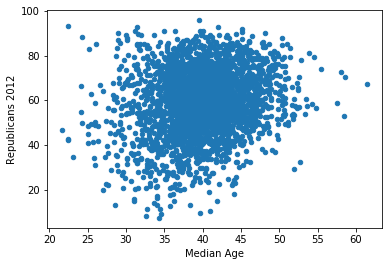

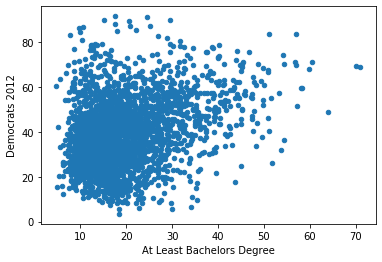

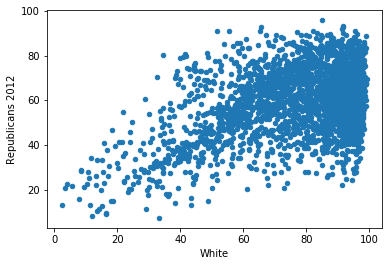

In [5]:
# Median Income vs Percent of Republican Voters"
data.plot.scatter('Median Age', 'Republicans 2012')

# Percent of Residents College Educated vs Percent of Democratic Voters"
data.plot.scatter('At Least Bachelors Degree', 'Democrats 2012')

# Percent of White Residents vs Percent of Republican Voters"
data.plot.scatter('White', 'Republicans 2012')

### Bar Graph

Emily

1) democrats and republicans by percentage in each profession
2) education levels for democrat and republican

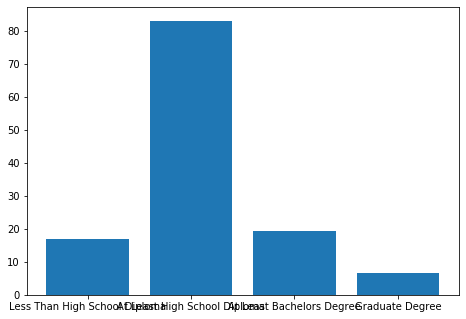

In [8]:
avg_lesshs = data['Less Than High School Diploma'].mean()
avg_hs = data['At Least High School Diploma'].mean()
avg_bach = data['At Least Bachelors Degree'].mean()
avg_grad = data['Graduate Degree'].mean()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x_cords = ['Less Than High School Diploma', 'At Least High School Diploma', 'At Least Bachelors Degree', 'Graduate Degree']
y_cords = [avg_lesshs, avg_hs, avg_bach, avg_grad]
ax.bar(x_cords,y_cords)
plt.show()

### Box Plots

The Box Plots below give us perspective on some key attributes in the dataset and help us understand what values for these attributes would be outliers

In [ ]:
print("Distribution of median income for 2010")
data.boxplot(['Median Earnings 2010'])

In [ ]:
print("Distribution of uninsured voters")
data.boxplot(['Uninsured'])

In [ ]:
print("Distribution of unemployed voters")
data.boxplot(['Unemployment'])

### Univariate analysis

In this part, we decided to look only at single features and trying to find analysis of central tendency and measures of dispersion. We calculated the mean, median, mode, standard deviation, minimum, maximum, and range of some features. We also did a box plot to visualize the data better and to find outliers. For most of the features we tested below, the central tendency tends to be close to each other, with relatively small standard deviation. However, the minimum, maximum, and box plots shows that many features have a fair amount of outliers, and these can skew the data heavily in certain methods such as K-nearest neighbor, so knowing which features have a lot of outliers is useful to know. 

In [ ]:
# do the analysis
def toPrint(string):
    print(string + ":")
    print("Mean: " + str(data[string].mean()))
    print("Median: " + str(data[string].median()))
    print("Mode: " + str(data[string].mode().iloc[0]))
    print("Standard Deviation: " + str(data[string].std()))
    print("Min: " + str(data[string].min()) + ", Max: " + str(data[string].max()) + ", Range: " + str(data[string].max() - data[string].min()))
    data.boxplot(column=[string])
    plt.show()
    print()

toPrint('At Least High School Diploma')
toPrint('At Least Bachelors Degree')
toPrint('Median Earnings 2010')
toPrint('Poverty Rate below federal poverty threshold')
toPrint('Management professional and related occupations')
toPrint('White')
toPrint('Median Age')
toPrint('Uninsured')
toPrint('Unemployment')

## Classifying the Data

In attempting to build the best model possible to classify our records, we will first test several different classification algorithms on our data and assess the performance of each of them. We will assess each of these algorithms on how accurate they are, and how well they handle class imbalance, and display the results of each of those algorithms. Below, we discuss these two meaures in more detail.

### 1) Accuracy

Each algorithm will be tested on the data using K-Fold Cross Validation with 10 folds. In the first iteration, the first tenth of the data set will serve as the testing data and have the labels removed. The rest of the dataset will serve as the training data which will be used to build the algorithm. Once the algorithm is built, the testing records will be fed into the algorithm and classified. The alrogithm's classification of those testing records will be compared to the actual labels of those testing records to determine the accuracy of that iteration. In the second iteration, the second tenth of the data set will serve as the testing data while the rest serves as the training data. And so forth until all 10 folds are completed. The accuracy of that algorithm will be the average accuracy among those 10 folds.

### 2) Class Imbalance

Our dataset contains significantly more Republican than Democratic records given that the Democratic population tends to be more concentrated in urban areas. If our model were to be making mostly Republican predictions and have thus a high accuracy rate, we would want to know if this is because the model can properly distinguish what a Republican county looks like or the model is simply giving Republican labels most of the time without making that distinction. Creating a confusion matrix would be a more effective way to analyze the performance of a model instead of simplying looking at it's accuracy rate.

In the matrix, the top left value is the number of True Positive Classifications (number of records classified Republican that were actually Republican. The Bottom left is the number of False Positive Classifications (number of records classified Republican that were actually Democratic). The top right is the number of False Negative Classifications (number of records classified Democratic that were actually Republican). And the bottom right is the nuumber of True Negative Classifications (number of records classified Democratic that were actually Democratic).

Thus, in this scenario, we are particulary interested in achieveing a low rate of False Positive Classifications to indicate that the algorithm isn't making mostly Republican predictions simply because the majority class is Republican.

Another way to analyze the algorithms performance under this Class Imbalance is calculating Precision and Recall. Precision is the probability that given a Repbulican classification, how likely is it to be correct. And Recall is the probability that given a Republican record, will it be classified as such. In this scenario, we are particularly interested in a high recall rate. The F-measure is also calculated which is a combination of both the precision and recall metric.

### Naive Bayes Algorithm

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
clf = GaussianNB()
clf.fit(features, labels)

# measuring accuracy
nested_score = cross_val_score(clf, features, labels, cv=10)
print("Accuracy of Naive Bayes Classifier:", nested_score.mean()*100)

# measuring class imblanace
predicted_score = cross_val_predict(clf, features, labels, cv = 10)
print(confusion_matrix(labels, predicted_score))
print()
print(classification_report(labels, predicted_score))

### Decision Tree Algorithm

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(features, labels)

# measuring accuracy
nested_score = cross_val_score(clf, features, labels, cv=10)
print("Accuracy of Decision Tree Classifier:", nested_score.mean()*100)

# measuring class imbalance
predicted_score = cross_val_predict(clf, features, labels, cv = 10)
print(confusion_matrix(labels, predicted_score))
print()
print(classification_report(labels, predicted_score))

### K-Nearest Neighbor Algorithm

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
knn = KNeighborsClassifier(n_neighbors=7)
pipeline = Pipeline(steps = [('standard_scaler', scaler), ('pca', pca), ('knn', knn)])
param_grid = {
    'pca__n_components': list(range(5, 20)),
    'knn__n_neighbors': list(range(1, 26))
}
grid = sk.model_selection.GridSearchCV(pipeline, param_grid, cv = 5)
grid.fit(features, labels)

k_val = grid.best_params_['knn__n_neighbors']
clf = sk.neighbors.KNeighborsClassifier(n_neighbors = k_val)
clf.fit(features, labels)

# measuring accuracy
nested_score = cross_val_score(clf, features, labels, cv=10)
print("Accuracy of KNN Classifier:", nested_score.mean()*100)

# measuring class imblanace
predicted_score = cross_val_predict(clf, features, labels, cv = 10)
print(confusion_matrix(labels, predicted_score))
print()
print(classification_report(labels, predicted_score))

### SVM Algorithm

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20)

pca = PCA()
scaler = StandardScaler()
svc = SVC(gamma='auto')

pipeline_svm = Pipeline([('scaler', scaler), ('pca', pca), ('svc', svc)])
param_grid = {
    'svc__kernel': ['linear', 'poly']
}

grid_search = GridSearchCV(pipeline_svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(features, labels)

# measuring accuracy
nested_score = cross_val_score(grid_search, features, labels, cv=5)
y_preds = cross_val_predict(pipeline_svm, features_test, labels_test, cv=10) 
print("Accuracy: ", nested_score.mean()*100, '\n')

# measuring class imblanace
predicted_score = cross_val_predict(svc, features, labels, cv = 10)
print(confusion_matrix(labels, predicted_score))
print()
print(classification_report(labels, predicted_score))

### Neural Net Algorithm

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_class = MLPClassifier()
pipeline_nn = Pipeline([('scaler', scaler), ('mlp_classifier', mlp_class)])

param_grid = {
    'mlp_classifier__hidden_layer_sizes': list(range(20, 40, 10)),
    'mlp_classifier__activation': ['logistic', 'tanh', 'relu']
}

grid_search = GridSearchCV(pipeline_nn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(features, labels)

# measuring accuracy
nested_score = cross_val_score(grid_search, features, labels, cv=5)
print("Accuracy: ", nested_score.mean()*100, '\n')

# measuring class imblanace
predicted_score = cross_val_predict(clf, features, labels, cv = 10)
print(confusion_matrix(labels, predicted_score))
print()
print(classification_report(labels, predicted_score))

## Feature Engineering

Feature Engineering is the process of creating new features in our dataset from a combination of exisiting features. Feature Engineering may improve the performance of the model by creating a feature that is more inditicative of political affiliation than exisiting features, reducing the total number of features that the algorithm has to work with, or a combination of both of these factors.

One feature we added was the percentage of residents in Professional industries by adding the percentage of residents in both management and sales occuptions. Residents working in both of these types of professions tend to be of similar economic status. We then deleted the two individual columns in exchange for this new addition, reducing the total number of features used by the algorithm.

In [ ]:
def voter_turnout (row):
    return (row['Votes'] / row['Total Population']) * 100

def minority(row):
    return (row['Black'] + row['Hispanic'] + row['Asian'] + row['Amerindian'] + row['Other Race'])

def professional(row):
    return (row['Management professional and related occupations'] + row['Sales and office occupations'])
    
def manufacturing(row):
    return (row['Farming fishing and forestry occupations'] + row['Construction extraction maintenance and repair occupations'] + row['Production transportation and material moving occupations'])
    
data1 = data.pop('Party Label')    
    
data['Voter Turnout'] = data.apply (lambda row: voter_turnout(row), axis=1)
data['Minority'] = data.apply (lambda row: minority(row), axis=1)
data['Professional'] = data.apply (lambda row: professional(row), axis=1)
data['Manufacturing'] = data.apply (lambda row: manufacturing(row), axis=1)

data = data.drop('Black', axis=1)
data = data.drop('Hispanic', axis=1)
data = data.drop('Asian', axis=1)
data = data.drop('Amerindian', axis=1)
data = data.drop('Other Race', axis=1)
data = data.drop('Management professional and related occupations', axis=1)
data = data.drop('Sales and office occupations', axis=1)
data = data.drop('Farming fishing and forestry occupations', axis=1)
data = data.drop('Construction extraction maintenance and repair occupations', axis=1)
data = data.drop('Production transportation and material moving occupations', axis=1)

data['Party Label'] = data1

data.head(10)

In [ ]:
labels = data['Party Label']
features = data.drop(['Party Label'], axis=1)

print("Features shape: " + str(features.shape))
print("Labels shape: " + str(labels.shape))
features.head()

## Optimizing Classification Algorithms

We will now run our classification algorithms again with the new features in our dataset to assess to what degree adding or removing certain attributes will affect the accuracy of classifying our data. We will thus display the accuracy and class imblance for each algorithm under these new conditions. Furthermore, there are potential ways that each individual classification algorithm can be optimized based on their unique characteristics and we will explore that as well.

### Naive Bayes Algorithm

In [ ]:
clf = GaussianNB()
clf.fit(features, labels)

# measuring accuracy
nested_score = cross_val_score(clf, features, labels, cv=10)
print("Accuracy of Naive Bayes Classifier:", nested_score.mean()*100)

# measuring class imblanace
predicted_score = cross_val_predict(clf, features, labels, cv = 10)
print(confusion_matrix(labels, predicted_score))
print()
print(classification_report(labels, predicted_score))

Naive Bayes has the assumption that all the features in the dataset are indepedent. However, some features are depedent on each other, for example, all the percentages of race will add up to 100%. The following will attempt to remove some features that are dependent on each other to see if it gives a different accuracy. As it turned out, the accuracy decreased.

In [ ]:
nb_data = data.copy()

nb_data = nb_data.drop('Fips', axis=1)
nb_data = nb_data.drop('Democrats 2012', axis=1)
nb_data = nb_data.drop('Democrats 2008', axis=1)
nb_data = nb_data.drop('Less Than High School Diploma', axis=1)
nb_data = nb_data.drop('Minority', axis=1)
nb_data = nb_data.drop('Voter Turnout', axis=1)
nb_data = nb_data.drop('Professional', axis=1)

nb_data.head(10)

In [ ]:
nb_labels = nb_data['Party Label']
nb_features = nb_data.drop(['Party Label'], axis=1)
nb_data.head()

print("Features shape: " + str(nb_features.shape))
print("Labels shape: " + str(nb_labels.shape))
nb_features.head()

clf = GaussianNB()
clf.fit(nb_features, nb_labels)

nested_score = cross_val_score(clf, nb_features, nb_labels, cv=10)
print("Accuracy:", nested_score.mean()*100)

predicted_score = cross_val_predict(clf, nb_features, nb_labels, cv = 10)
print(confusion_matrix(nb_labels, predicted_score))
print()
print(classification_report(nb_labels, predicted_score))

### Decision Tree Algorithm

In [ ]:
labels = data['Party Label']
features = data.drop(['Party Label'], axis=1)

clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(features, labels)

# measuring accuracy
nested_score = cross_val_score(clf, features, labels, cv=10)
print("Accuracy of Decision Tree Classifier:", nested_score.mean()*100)

# measuring class imbalance
predicted_score = cross_val_predict(clf, features, labels, cv = 10)
print(confusion_matrix(labels, predicted_score))
print()
print(classification_report(labels, predicted_score))

The Decision Tree algorithm is prone to overfitting the given dataset by growing extensively to the point where data fragmentation occurs, causing the algorithm to perform less accurately on new test data. To combat this, we can specify a max tree size for the algorithm which is the maximum number of levels that the tree can grow to. We tried max tree sizes of 5, 10, 15, 20 and 25 to determine which tree size performed the most effectively. The tree size that worked the best was 20 levels.

In [ ]:
for x in range(5, 30, 5):
    
    # Max Depth of x
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=x)
    clf.fit(features, labels)

    # measuring accuracy
    nested_score = cross_val_score(clf, features, labels, cv=10)
    print("Accuracy of Decision Tree Classifier with Max Depth of " + str(x) + ":", nested_score.mean()*100)

    # measuring class imbalance
    predicted_score = cross_val_predict(clf, features, labels, cv = 10)
    print(confusion_matrix(labels, predicted_score))
    print()
    print(classification_report(labels, predicted_score))


### KNN Algorithm

In [ ]:
scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
knn = KNeighborsClassifier(n_neighbors=7)
pipeline = Pipeline(steps = [('standard_scaler', scaler), ('pca', pca), ('knn', knn)])
param_grid = {
    'pca__n_components': list(range(1, 15)),
    'knn__n_neighbors': list(range(1, 26))
}
grid = sk.model_selection.GridSearchCV(pipeline, param_grid, cv = 5)
grid.fit(features, labels)

k_val = grid.best_params_['knn__n_neighbors']
clf = sk.neighbors.KNeighborsClassifier(n_neighbors = k_val)
clf.fit(features, labels)

# measuring accuracy
nested_score = cross_val_score(clf, features, labels, cv=10)
print("Accuracy of KNN Classifier:", nested_score.mean()*100)

# measuring class imblanace
predicted_score = cross_val_predict(clf, features, labels, cv = 10)
print(confusion_matrix(labels, predicted_score))
print()
print(classification_report(labels, predicted_score))

The K-Nearest Neighbor algorithm is affected by class imbalances - if there is an uneven ratio of one class label to another, it may predict that the majority class is more likely, simply because it has more records. To combat this, we will weight points by the inverse of their distance. In this case, closer neighbors of a query point will have a greater influence than neighbors which are further away. As it so happens, this caused the accuracy to decrease.

In [ ]:
scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
knn = KNeighborsClassifier(n_neighbors=7, weights='distance')
pipeline = Pipeline(steps = [('standard_scaler', scaler), ('pca', pca), ('knn', knn)])
param_grid = {
    'pca__n_components': list(range(1, 15)),
    'knn__n_neighbors': list(range(1, 26))
}
grid = sk.model_selection.GridSearchCV(pipeline, param_grid, cv = 5)
grid.fit(features, labels)

k_val = grid.best_params_['knn__n_neighbors']
clf = sk.neighbors.KNeighborsClassifier(n_neighbors = k_val, weights='distance')
clf.fit(features, labels)

# measuring accuracy
nested_score = cross_val_score(clf, features, labels, cv=10)
print("Accuracy of Weighted KNN Classifier:", nested_score.mean()*100)

# measuring class imblanace
predicted_score = cross_val_predict(clf, features, labels, cv = 10)
print(confusion_matrix(labels, predicted_score))
print()
print(classification_report(labels, predicted_score))

### SVM Algorithm

Unlike greedy algorithms such as the Decision Tree algorithm, the SVM algorithm can be configured to find the most optimal solution to a problem (known as the global minimum) rather than a solution that is optimal in the given circumstances, but not necessary the most optimal overall (known as the local minimum). The issue is that configuring the right kernel function for SVM to find the global minimum is difficult. Below, we try to find a more optimal solution with a different kernel setting.

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20)

svc = SVC(gamma='auto', degree=8)

#TESTING SIGMOID KERNEL 
print("SIGMOID KERNEL:\n")
svc = SVC(kernel='sigmoid')
svc.fit(features_train, labels_train)
y_pred = svc.predict(features_test)
print(confusion_matrix(labels_test, y_pred))
print(classification_report(labels_test, y_pred))

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20)

#TESTING SIGMOID KERNEL 
print("RBF KERNEL:\n")
svc = SVC(kernel='rbf')
svc.fit(features_train, labels_train)
y_pred = svc.predict(features_test)
print(confusion_matrix(labels_test, y_pred))
print(classification_report(labels_test, y_pred))

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20)

#TESTING SIGMOID KERNEL 
print("POLY KERNEL:\n")
svc = SVC(kernel='sigmoid')
svc.fit(features_train, labels_train)
y_pred = svc.predict(features_test)
print(confusion_matrix(labels_test, y_pred))
print(classification_report(labels_test, y_pred))


### Neural Net Algorithm

Like the SVM algorithm, the Neural Net Algorithm can also find the global minimum of a solution when trained correctly. However, the Neural Net Algorithm can also get stuck at a local minimum when not trained optimally. Below, we will try training the Neural Net Algorithm with different Hidden Layer Values to attempt to find the global minimum.

In [ ]:
###USING relu activation fuction bc it was found to be the most accurate when isolated

for x in range(15, 60, 20):
    
    nn_class = MLPClassifier(hidden_layer_sizes= x, activation='relu')
    scores = cross_val_score(nn_class, features, labels, cv=5)
    print("Accuracy of " + x + " hidden layers: ", scores.mean()*100)
    predicted_score = cross_val_predict(clf, features, labels, cv = 10)
    print(confusion_matrix(labels, predicted_score))
    print()
    print(classification_report(labels, predicted_score))
    

## Ensembling

Rather than simplying selecting the highest performing classification algorithm with the most optimal features to classify our data, we can create an even more accurate prediction algorithm by identifying the unique benefits of each classification algorithm, then combining and taggregating the results of multiple algorithms. This is called Ensembling. There are two types of Ensembles. Homogenous Enesemble Classifiers aggregate multiple results of the same type of classification algorithm. Heterogenous Voting Classifiers aggregate multiple results from different types of classification algorithms. Below, we explore a few different Ensembleings to determine the most optimal algorithm for our data.

### Homogenous Bagging Ensemble

A Homogenous Bagging Ensemble trains the same classification algorithm multiple different times, but each algorithm is trained with a different randomly selected sample from the dataset. Replacement is obsevered when each of the samples are selected. Below, we will run the bagging ensemble with three different types of classification algorithms. After testing many different classification algorithms above, these three were determined to have the best combination of overall performance and efficiency.

In [ ]:
from sklearn.ensemble import BaggingClassifier

# With Decision Trees
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=20))
clf.fit(features, labels)
nested_score = cross_val_score(clf, features, labels, cv=10)
print("Accuracy with Decision Trees: ", nested_score.mean()*100, '\n')

predicted_score = cross_val_predict(clf, features, labels, cv = 10)
print(confusion_matrix(labels, predicted_score))
print()
print(classification_report(labels, predicted_score))

# With Naive Bayes
clf = BaggingClassifier(base_estimator=GaussianNB())
clf.fit(features, labels)
nested_score = cross_val_score(clf, features, labels, cv=10)
print("Accuracy with Naive Bayes: ", nested_score.mean()*100, '\n')

predicted_score = cross_val_predict(clf, features, labels, cv = 10)
print(confusion_matrix(labels, predicted_score))
print()
print(classification_report(labels, predicted_score))

# With SVM

# TODO: use param grid to get correct kernel? Use most optimal kernel settings found earlier
clf = BaggingClassifier(base_estimator=SVC(gamma='auto'))
clf.fit(features, labels)
nested_score = cross_val_score(clf, features, labels, cv=10)
print("Accuracy with SVM: ", nested_score.mean()*100, '\n')

predicted_score = cross_val_predict(clf, features, labels, cv = 10)
print(confusion_matrix(labels, predicted_score))
print()
print(classification_report(labels, predicted_score))

### Homogenous Random Forest Ensemble With Decision Trees

The Random Forest Ensemble is a type of Homogenous Bagging Ensemble that uses Decision Trees. However, Random Forest is unique in that when each Decision Tree is being built, each Decision Tree is only allow to split at a given subset of features at a given point instead of getting to consider all features to split on at every level of building the tree. This in turn creates more variation between the Decision Trees being used in the Ensemble as opposed to running Bagging without Random Forest.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline(steps = [('rfc', RandomForestClassifier())])
param_grid = {
    # determined above that 20 was the most optimal value for max_depth
    'rfc__max_depth': [20],
    'rfc__min_samples_leaf': [8,10,12],
    'rfc__max_features': ["sqrt", "log2"]
    
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(features, labels)
nested_score = cross_val_score(grid_search, features, labels, cv = 5)
print("Accuracy:", nested_score.mean()*100)

### Homogenous Boosting Ensemble

A boosting ensembler builds and trains several classifiers sequentially, and each time, the data sampling depends on the performance of previously generated models. Boosting begins by fitting a classifier on the original dataset, then fitting additional copies of the classifier on a weighted dataset (where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases).

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20)

#with Decision Trees -- adaBooster uses decision trees as its default base classifier 
dt_boost = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(dt_boost, features, labels, cv=5)
print("Accuracy ADA BOOST:", scores.mean()*100)
y_preds = cross_val_predict(dt_boost, features_test, labels_test, cv=10) 
print("Classification report: \n", classification_report(labels_test, y_preds, labels=[0,1]))
 
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

#Gradient Boosting
g_boost = GradientBoostingClassifier(n_estimators=100)
scores = cross_val_score(g_boost, features, labels, cv=5)
print("Accuracy GRADIENT BOOST:", scores.mean()*100)
y_preds = cross_val_predict(g_boost, features_test, labels_test, cv=10) 
print("Classification report: \n", classification_report(labels_test, y_preds, labels=[0,1]))

### Heterogeneous Stacked Ensemble Using Decision Trees, Naive Bayes, and SVM:

In [ ]:
from sklearn.ensemble import StackingClassifier

# creating the different classifiers
clf_1 = DecisionTreeClassifier(criterion='entropy')
clf_2 = GaussianNB()
clf_3 = SVC(gamma='auto')

estimators = [('dt', clf_1), ('nb', clf_2), ('svm', clf_3)]


clf = StackingClassifier(estimators=estimators)
acc = clf.fit(features_train, labels_train).score(features_test, labels_test)
print("Accuracy:", acc*100)

After running a variety of different Ensemblings, we determined that the AdaBoost Homogenous Classifier with Decision Trees as the base classifier was the best performing Ensembling based on accuracy, dealing with class imbalance, and efficiency. This is thus the algorithm that we will use to classify our data.

## ROC Curve

A ROC Curve illustrates the alrogithm's trade off between its True Positive Rate and True Negative Rate. Below, we will compute the ROC Curve for our best Ensembling Algorithm which is the AdaBoost Homogenous Classifier with Decision Trees. The higher percentage of the graph area that is under the curve (AUC or Area Under the Curve), the more accurate the algorithm is. An AUC value of 50% indicates that the algorithm is about as good as random guessing, and the algorithm clearly performs well beyond that.

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20)

dt_boost = AdaBoostClassifier(n_estimators=100)
dt_boost.fit(features_train, labels_train)

proba = dt_boost.predict_proba(features_test)
fpr_result, tpr_result, thresholds = roc_curve(labels_test, proba[:,1])
fpr, tpr = fpr_result, tpr_result

print(roc_auc_score(labels_test, proba[:,1]))

plt.plot([0,1],[0,1],'k--') #plot the diagonal line
plt.plot(fpr, tpr, label='NB') #plot the ROC curve
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve Naive Bayes')
plt.show()